In [ ]:
!pip install requests requests_oauthlib

## Getting the data from twitter

In [20]:
import requests
import pandas as pd
from requests_oauthlib import OAuth1

In [22]:
API_KEY = "API_KEY"
API_SECRET_KEY = "API_SECRET_KEY"
ACCESS_TOKEN = "ACCESS_TOKEN"
ACCESS_TOKEN_SECRET = "TOKEN_SECRET"

auth = OAuth1(API_KEY, API_SECRET_KEY, ACCESS_TOKEN, ACCESS_TOKEN_SECRET)

In [25]:
def get_follow_details(name):
  foll = []
  cursor = -1

  while len(foll) < 1000:
    url = f"https://api.twitter.com/1.1/followers/list.json?screen_name={name}&count=200&cursor={cursor}"
    response = requests.get(url, auth=auth)

    if response.status_code != 200:
      raise Exception(f'Error ocurred! Reason:{response.text}')

    data = response.json()
    foll.extend(data['users'])
    cursor = data['next_cursor']

    if cursor == 0:
      break

  return foll


In [30]:
def helper():
  name = 'opensea'
  foll = get_follow_details(name)

  follow_details = []
  for i in foll:
    follow_details.append({
        "Screen name": i["screen_name"],
        "Follower count": i["followers_count"],
        "Verified": i["verified"],
        "Location": i["location"],
        "Description": i["description"]
        })
    
  df = pd.DataFrame(follow_details)
  df.to_csv("Follower_data.csv", index = False)

  #print(df.head())

In [ ]:
helper()

## Visualising the data

Description:         Follower count  Following count
count     1000.000000      1000.000000
mean       656.971000       448.159000
std       3847.151251      2091.792183
min          0.000000         1.000000
25%          3.000000        25.000000
50%         11.000000        66.000000
75%         64.250000       235.500000
max      61460.000000     44114.000000


Missing values:  Screen name          0
Follower count       0
Verified             0
Following count      0
Location           680
Description        409
dtype: int64


Verified Counts:  False    999
True       1
Name: Verified, dtype: int64


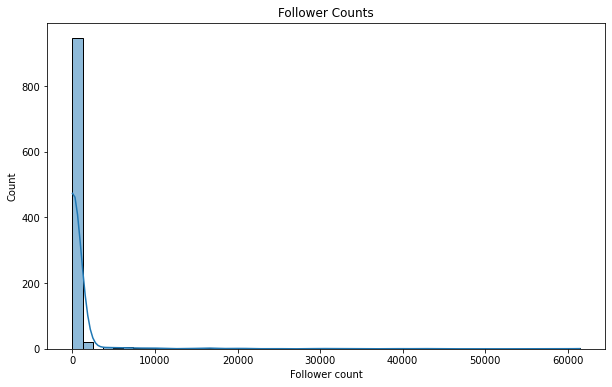

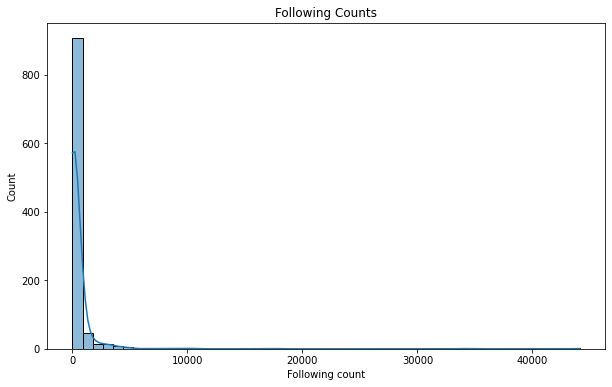

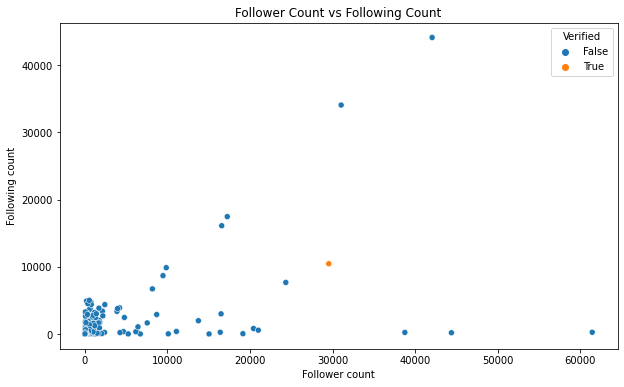

India              5
United States      4
Los Angeles, CA    4
Metaverse          4
Lagos, Nigeria     3
USA                3
Украина            3
İstanbul           3
日本                 3
Nigeria            3
Name: Location, dtype: int64


/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Glyph 26085 (\N{CJK UNIFIED IDEOGRAPH-65E5}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Glyph 26412 (\N{CJK UNIFIED IDEOGRAPH-672C}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


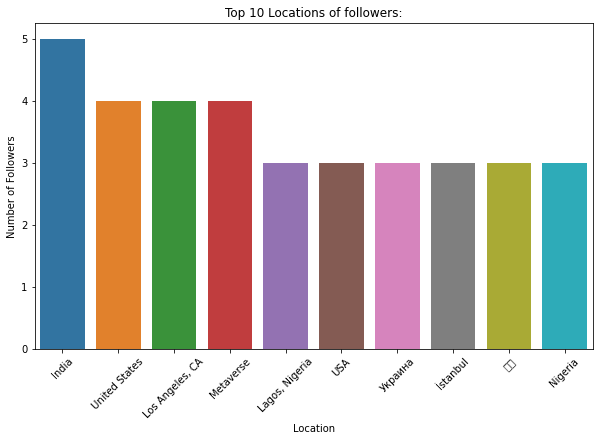

In [34]:
# Some visualisations---------------------

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("Follower_data.csv")

print("Description: ",df.describe())

print("\n\nMissing values: ",df.isna().sum())

verified_counts = df["Verified"].value_counts()
print("\n\nVerified Counts: ",verified_counts)

# Follower counts
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x="Follower count", bins=50, kde=True)
plt.title("Follower Counts")
plt.show()

# Following counts
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x="Following count", bins=50, kde=True)
plt.title("Following Counts")
plt.show()

# Correlation between follower count and following count
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x="Follower count", y="Following count", hue="Verified")
plt.title("Follower Count vs Following Count")
plt.show()

# Top 10 locations by follower count
top_locations = df["Location"].value_counts().nlargest(10)
print(top_locations)

# Visualize top 10 locations
plt.figure(figsize=(10, 6))
sns.barplot(x=top_locations.index, y=top_locations.values)
plt.title("Top 10 Locations of followers:")
plt.xlabel("Location")
plt.ylabel("Number of Followers")
plt.xticks(rotation=45)
plt.show()


## Performing Classification on data to predict verification of user

In [44]:
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.ensemble import RandomForestClassifier

Feature Engineering

In [46]:
# Creating Follower to Following ratio:
df['followers_to_following_ratio'] = df['Follower count'] / df['Following count']
df['followers_to_following_ratio'].replace(np.inf, -1, inplace=True)

# Cleaning text from description column:
def clean_text(text):
    if isinstance(text, str):
        text = text.lower()
        text = re.sub(r'[^a-z0-9\s]', '', text)
        text = re.sub(r'\s+', ' ', text).strip()
    else:
        text = ''
    return text

df['Description'] = df['Description'].apply(clean_text)
# Mapping Verified Boolean to int(1, 0) values
y = df['Verified'].map({False: 0, True: 1})

# Splitting into train and test:
X = df.drop("Verified", axis=1)
y = df["Verified"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [47]:
preprocessor = ColumnTransformer(transformers=[
    ('tfidf_desc', TfidfVectorizer(), 'Description'),
    ('scaler_follower', StandardScaler(), ['Follower count']),
    ('scaler_following', StandardScaler(), ['Following count']),
    ('scaler_ratio', StandardScaler(), ['followers_to_following_ratio'])
], remainder='drop')

# Using Random Forest Classifier
classifier = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', RandomForestClassifier(class_weight='balanced', random_state=42))
])

classifier.fit(X_train, y_train)

# Predict on the test set
y_pred = classifier.predict(X_test)

# Evaluate the classifier
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 1.0
              precision    recall  f1-score   support

       False       1.00      1.00      1.00       200

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



Some thoughts on the challenge:
1. I think the data set is too small hence the predictions are really good.
2. Just using follower count, following count, location and Description is not good enough as samples
3. These values dont seem to hold a lot of influence in the predcition of verification.
4. To improve, we could try using the tweets of the user and applying Sentiment Analysis on it.
5. I tried using SMOTE and imblearn to help with the prediction but data was too small for that.
6. If given more time, I could use some better feature engineering methods and play with the hyper parameters